# Grupo Otto
## Usando sklearn :D

In [1]:
import numpy as np
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import cross_validation
from sklearn import linear_model, decomposition, svm
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split


In [2]:
# Extraemos los datos del archivo sin el primero renglon
data = np.genfromtxt("train.csv", delimiter = ",", converters = {94: lambda s: int(s[-1])}, dtype = "int", skip_header = 1)
# Almacenamos nuestro target
target = data[:,-1]
# Borramos la primera columna y la ultima, no las necesitamos mas
data = np.delete(data, 0, axis = 1)
data = np.delete(data, -1, axis =1)

# Cargamos los datos de posteriormente usaremos para la prediccion
test = np.genfromtxt("test.csv", delimiter = ",", skip_header = 1, dtype = "int")

test = np.delete(test, 0, axis = 1)
print "Target:", target.shape
print "Datos:", data.shape

Target: (61878,)
Datos: (61878, 93)


In [5]:
# Primeramente use una regresion logistica sin regularizar para hacer el primer
# submission 

logistic = linear_model.LogisticRegression()
logistic.fit(data, target)
y_est = logistic.predict_proba(test)
y_est

array([[  1.92631575e-04,   2.21083246e-01,   3.63206584e-01, ...,
          1.31207733e-02,   5.27481763e-06,   2.79165136e-07],
       [  3.46187636e-04,   9.42216754e-02,   2.77431264e-04, ...,
          1.87603937e-03,   3.35789341e-01,   1.64385376e-03],
       [  4.33166147e-04,   2.07455383e-04,   7.36179069e-05, ...,
          6.53814479e-04,   7.11110219e-04,   4.89960721e-05],
       ..., 
       [  6.20930127e-12,   2.36446967e-01,   6.07271244e-01, ...,
          6.27241538e-03,   7.61598326e-08,   1.68089908e-09],
       [  3.11575954e-04,   6.69609205e-01,   1.56549653e-01, ...,
          3.04055151e-03,   1.17181476e-03,   3.61595893e-04],
       [  2.24108698e-03,   4.21739026e-01,   3.69675980e-01, ...,
          1.05879460e-01,   1.42509229e-04,   4.76231981e-04]])

In [4]:
# Funcion plagiada de la web de sklearn para graficar curvas de aprendizaje bonitas

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    es : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

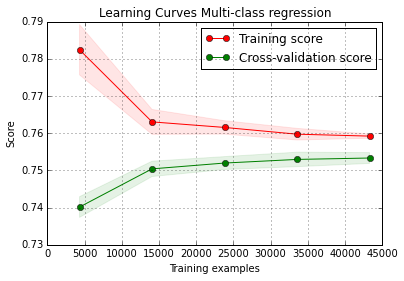

termine


In [6]:
# Vamos a ver que nos dice la curva acerca de mi algoritmo de aprendizaje,
# con CV revolviendo el split y partiendo mis datos (30% para datos de
# testing)
title = "Learning Curves Multi-class regression"
cv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,
                                   test_size=0.3)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=4)

plt.show()
print "termine"


In [ ]:
# A pesar de que la curva no me indique necesidad de regularizar
# tambien grafica con C = 10, dandome como resultado algo muy similar a lo anterior.

In [12]:
# Segun la curva de aprendizaje que se arroja, el aumentar el numero de muestra
# no ayudaria mucho (a parte no seria un opcion ya que no puedo pedir mas datos),
# los dos score's se empiezan a parecer bastante bien
# a partir de 20000 datos de entrenamiento. Tambien no aparece un score tan alto
# como para aplicar regularizacion. (Aunque lo intente y no sirvio)
# Segun una discusion en el foro de la competencia, la reduccion de
# dimensionalidad tampoco es tan util (en este caso), pero podemos intentarlo
# y despues hacer una expansion polinomial para reducir un poco el bias.

pca = decomposition.PCA(n_components = 60)
pca.fit(data)
pca_data = pca.transform(data)
#pca_test = pca.transform(test)
pca_data.shape

(61878, 60)

In [16]:
# expansion cuadratica
poly = PolynomialFeatures(2)
pca_exp_data = poly.fit_transform(data)

# Aqui sacare otra curva de aprendizaje para ver que resultados tengo despues
# de haber hecho la expansion polinomial. Pero lo siguiente no funcionara
# ya que al tratar de hacer la expansion me lanza un error de memoria.
# En caso de haber obtenido un mejor score quiza hubiera sido bueno
# (y dependiendo de lo que arroje la curva), ahora si, usar regularizacion
# para poder generalizar mejor.
title = "Learning Curves Multi-class regression"
cv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,
                                   test_size=0.3, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, pca_exp_data, target, cv=cv, n_jobs=4)
plt.show()

MemoryError: 

In [24]:
# Aqui solo cargamos los datos con los que vamos a predecir y hacer submissions..

test = np.genfromtxt("test.csv", delimiter = ",", skip_header = 1, dtype = "int")
test = np.delete(test, 0, axis = 1)

In [14]:
test.shape

(144368, 93)

In [11]:
###///////       SUPPORT VECTOR MACHINE      /////////###
# Tambien probe con maquinas de vector de soporte con kernel lineal,
# ya que otro tipo de kernel nunca pude correr bien el algoritmo
# me trababa mi maquina. Pero hice un submission con estas predicciones
# y fue la que me dio mejor calificacion ( aunque no mucha diferencia )
clf = svm.SVC(kernel = "linear")
clf.fit(data, target)
yest = clf.predict_proba(test)
print "Ajustado.."

KeyboardInterrupt: 

In [ ]:
id = np.arange(1, yest.shape[0] + 1)
print id.shape, yest.shape
yest = np.concatenate((id.reshape(-1,1).astype(object), yest), axis = 1)
yest.shape
print yest
np.savetxt("sub2.csv", yest, delimiter = ",", fmt = "%s")
print "finished"

In [19]:
"""
////////////////////////////////////////////////////
///  USANDO ANALISIS DE COMPONENTES PRINCIPALES  ///
////////////////////////////////////////////////////
"""

# Tambien use este ejemplo de la web de Sklearn para buscar exhaustivamente
# (con gridsearch) el parametro C de regularizacion (aunque teniendo en
# mente que quisa no sea necesario regularizar aun), que mejor ajusta, pero
# no obtuve buenos resultados.

logistic = linear_model.LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps = [('pca', pca), ('logistic', logistic)])
pca.fit(data)
plt.figure(1, figsize =(4,3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth = 2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
                
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

estimator = GridSearchCV(pipe,
                        dict(pca__n_components = n_components,
                            logistic__C = Cs))
estimator.fit(data, target)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
           linestyle=':', label = 'n_components chosen')
plt.legend(prop = dict(size = 12))
plt.show()


In [ ]:
# Este bloque nunca quizo correr (o lo hizo pero nunca mostro la grafica)

title = "Learning Curves Multi-class regression"
cv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,
                                   test_size=0.3)
estimator = svm.LinearSVC() #dejamos un maximo de 1000 iteraciones
plot_learning_curve(estimator, title, pca_data, target, cv=cv, n_jobs=4)

plt.show()
print "termine"

In [9]:
"""
Probando la clasificacion con Bosques Aleatorios

Aqui obtuve un mejor score de precision comparado con los otros metodos
que probe, aunque lo hice usando los mismos datos con los que entrene
y eso no es nada bueno.
"""

clf = RandomForestClassifier()
clf = clf.fit(data, target)
yest = clf.predict_proba(test)
print clf.score(data, target)

# Despues lo corrobore sacando la curva de aprendizaje, dando
# como resultado un alto bias (igual que en las otras curvas sacadas)
# para los datos usados en CV.

title = "Learning Curves Multi-class regression"
cv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,
                                   test_size=0.3)
estimator = RandomForestClassifier() #dejamos un maximo de 1000 iteraciones
plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=4)

plt.show()


0.992549856169


'\n#svc = svm.SVC(kernel = "linear")\n#svc.fit(data, target).score(data, target)\n\ntitle = "Learning Curves Multi-class regression"\ncv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,\n                                   test_size=0.3)\nestimator = RandomForestClassifier() #dejamos un maximo de 1000 iteraciones\nplot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=4)\n\nplt.show()\n'

In [12]:
"""
Tambien probe con el metodo de ensamble visto en clase AdaBoosting
el cual no me dio mejora en los sumbissions que hice.
Analisando la curva de aprendizaje usando este metodo y arboles de decision
como el estimador base, se ve que los scores (de entrenamiento y de prueba) se
aproximan bastante, pero igual lo que me dan a entender es que mi algoritmo
presenta alto bias y necesito utilizar un metodo o caracteristicas mas complej@s.
"""

title = "Learning Curves Multi-class regression"
cv = cross_validation.ShuffleSplit(data.shape[0], n_iter=10,
                                   test_size=0.3)
estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators = 100) #dejamos un maximo de 1000 iteraciones
plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=4)

plt.show()


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-12-22a9b01d8177>, line 16)

In [13]:
"""
De acuerdo con las observaciones que puede hacer, con el trabajo hecho,
me quedo con la idea de que es necesario utilizar quiza otro metodo mas complejo
o usar caracteristicas de mis datos mas especificas o mas complejas tambien (esto
porque en ningun momento note que hubiera alta varianza). Desafortunadamente
no pude checar curvas de aprendizaje usando PCA y expansion polinomial.
En comentarios vistos en el foro de la competencia, asi como scripts, se ve que
la gente usa varios metodos de aprendizaje y un analisis mucho mas profundo.
Sin lugar a duda muchos de los conceptos y tecnicas vistas en clase para el
aprendizaje maquina, quedaron mucho mas claros con esta experiencia.
Nota, quite los bloques donde hacia la prediccion y el archivo submission,
solo lo deje cuando uso SVM, ya que con ello obtuve los resultados mas altos.
"""

'\nDe acuerdo con las observaciones que puede hacer, con el trabajo hecho,\nme quedo con la idea de que es necesario utilizar quiza otro metodo mas complejo\no usar caracteristicas de mis datos mas especificas o mas complejas tambien (esto\nporque en ningun momento note que hubiera alta varianza). Desafortunadamente\nno pude checar curvas de aprendizaje usando PCA y expansion polinomial.\nEn comentarios vistos en el foro de la competencia, asi como scripts, se ve que\nla gente usa varios metodos de aprendizaje y un analisis mucho mas profundo.\nSin lugar a duda muchos de los conceptos y tecnicas vistas en clase para el\naprendizaje maquina, quedaron mucho mas claros con esta experiencia.\nNota, quite los bloques donde hacia la prediccion y el archivo submission,\nsolo lo deje cuando uso SVM, ya que con ello obtuve los resultados mas altos.\n'